In [46]:


import torch as th
import torch.distributions as dist

import numpy as np

import networkx as nx

import pandas as pd

import matplotlib.pyplot as plt

class ProdGraph:
    def __init__(self, adjacency, distributions, initialization, buffer_limits, batch_size=100):
        self.adjacency = th.tensor(adjacency)
        self.distributions = distributions
        
        G = nx.DiGraph(adjacency)
        topological_order = th.tensor(list(nx.topological_sort(G)))
        self.topological_order = topological_order
        
        self.remaining_time = th.zeros(adjacency.shape[0])
        self.states = th.zeros((adjacency.shape[0], adjacency.shape[0]))
        self.output_buffer = th.zeros(adjacency.shape[0])
        self.input_buffer = th.zeros(adjacency.shape[0])
        self.buffer_limits = th.tensor(buffer_limits)
        self.n_nodes = adjacency.shape[0]
        self.batch_size = batch_size
                  
        
        
        # Initialize
        self.states = th.tensor(initialization)
        
        for i in range(self.n_nodes):
            self.remaining_time[i] = distributions[i].sample()
            if th.sum(self.adjacency[:, i]) == 0:
                self.input_buffer[i] = th.inf
                
        self.lapsed_time = 0
        
        self.log_entries = []
        
        self.output_data = th.zeros((self.batch_size, 5))
        self.batch_counter = 0
        self.log = None
        
        
    def add_to_log(self, data):
        
        if self.batch_counter == self.batch_size:
            self.log = pd.concat([self.log, pd.DataFrame({'time': self.output_data[:, 0].cpu().detach(), 
                                                           'node': self.output_data[:, 1].cpu().detach(), 
                                                           'input_buffer': self.output_data[:, 2].cpu().detach(), 
                                                           'output_buffer': self.output_data[:, 3].cpu().detach(), 
                                                           'state': self.output_data[:, 4].cpu().detach()})])
            self.output_data = th.zeros((self.batch_size, 5))
            self.batch_counter = 0
        else:
            self.output_data[self.batch_counter] = th.tensor(data)
            self.batch_counter += 1
            
        
    def forward(self):
        
        # Define entry point
        remaining_time = th.where(self.states[:, 0] * self.remaining_time > 0, self.remaining_time, float('inf'))
        min_value, entry_index = th.min(remaining_time, dim=0)
        
        # Adjust times
        lapsed_time = min_value.item()
        self.remaining_time -= lapsed_time * self.states[:, 0]
        self.lapsed_time += lapsed_time
        
        # Get current topological order
        topological_index_entry_node = th.where(self.topological_order == entry_index)[0].item()
        current_topological_order = [self.topological_order[(topological_index_entry_node + i) % self.n_nodes] for i in range(self.n_nodes)]
        
        # Iterate through graph
        for node_index in current_topological_order:
            # Move supplies from output to input
            
            supply_vec = self.adjacency[:, node_index]
            if th.sum(supply_vec) > 0:
                num_supply_sets = th.min(th.nan_to_num(self.output_buffer / supply_vec, nan=float('inf')))
                if num_supply_sets >= 1 and self.input_buffer[node_index] == 0:
                    self.output_buffer -= supply_vec
                    self.input_buffer[node_index] = 1
                
            # Case producing
            if self.states[node_index, 0] == 1:
                # Check if this node 
                if self.remaining_time[node_index] == 0:
                    # Check if the part is finished
                    if self.output_buffer[node_index] < self.buffer_limits[node_index]:
                        self.output_buffer[node_index] += 1
                        
                        if self.input_buffer[node_index] > 0:
                            # Start next part
                            self.remaining_time[node_index] = self.distributions[node_index].sample()
                            self.input_buffer[node_index] -= 1
                            self.add_to_log([self.lapsed_time, node_index.item(), self.input_buffer[node_index].item(), self.output_buffer[node_index].item(), 0])
                        else:
                            # Switch to starved
                            self.states[node_index, 0] = 0
                            self.states[node_index, 1] = 1
                            self.add_to_log([self.lapsed_time, node_index.item(), self.input_buffer[node_index].item(), self.output_buffer[node_index].item(), 1])
                    
                    else:
                        # Switch to blocked
                        self.states[node_index, 0] = 0
                        self.states[node_index, 2] = 1
                        self.add_to_log([self.lapsed_time, node_index.item(), self.input_buffer[node_index].item(), self.output_buffer[node_index].item(), 2])
                        
            # Case Starved 
            elif self.states[node_index, 1] == 1:
                # Check if supplies are now here
                if self.input_buffer[node_index] > 0:
                    # Start producing
                    self.input_buffer[node_index] -= 1
                    self.remaining_time[node_index] = self.distributions[node_index].sample()
                    
                    # Switch to producing state
                    self.states[node_index, 0] = 1
                    self.states[node_index, 1] = 0
                    self.add_to_log([self.lapsed_time, node_index.item(), self.input_buffer[node_index].item(), self.output_buffer[node_index].item(), 0])
                
            # Case Blocked 
            elif self.states[node_index, 2] == 1:
                # Check if space in buffer
                if self.output_buffer[node_index] < self.buffer_limits[node_index]:
                    self.output_buffer[node_index] += 1
                    
                    if self.input_buffer[node_index] > 0:
                        # Start next part
                        self.remaining_time[node_index] = self.distributions[node_index].sample()
                        self.input_buffer[node_index] -= 1
                        
                        # Switch to producing state
                        self.states[node_index, 0] = 1
                        self.states[node_index, 2] = 0
                        self.add_to_log([self.lapsed_time, node_index.item(), self.input_buffer[node_index].item(), self.output_buffer[node_index].item(), 0])
                    else:
                        # Switch to starved
                        self.states[node_index, 1] = 1
                        self.states[node_index, 2] = 0
                        self.add_to_log([self.lapsed_time, node_index.item(), self.input_buffer[node_index].item(), self.output_buffer[node_index].item(), 1])


In [91]:
import numpy as np
import math
import torch as th

# Function to generate a random DAG adjacency matrix
def generate_random_dag(n, density):
    # Initialize adjacency matrix with zeros
    adjacency_matrix = np.zeros((n, n), dtype=int)
    
    # Create directed edges randomly
    for i in range(n):
        # Choose a random target node for the outgoing edge
        if i + 1 < n:
            target_node = np.random.randint(i + 1, n)
            adjacency_matrix[i, target_node] = 1
    
    return adjacency_matrix

def generate_random_distributions(n, expected_value, distribution_types=['uniform', 'normal', 'exponential']):
    distributions = []
    mean = expected_value
    
    for _ in range(n):
        distribution_type = np.random.choice(distribution_types)
        
        if distribution_type == 'uniform':
            # Generate a random uniform distribution within a reasonable range
            low = mean - math.sqrt(3)
            high = mean + math.sqrt(3)
            distributions.append(th.distributions.Uniform(low, high))
            
        elif distribution_type == 'normal':
            # Generate a random normal distribution with mean and standard deviation adjusted for the number of distributions
            std_dev = 1 / math.sqrt(n)
            distributions.append(th.distributions.Normal(mean, std_dev))
            
        elif distribution_type == 'exponential':
            # Generate a random exponential distribution with mean adjusted for the number of distributions
            lambd = 1 / mean
            distributions.append(th.distributions.Exponential(1 / lambd))
    
    return distributions

def plot_time_series_color(graph, n):
    # Create a figure and axis for each subplot
    fig, axs = plt.subplots(n, 1, sharex=True, figsize=(8, 1*n))
    
    # Define color mapping
    colors = {0: 'green', 1: 'yellow', 2: 'red'}
    
    # Plot each time series with colored backgrounds
    for i, ax in enumerate(axs):
        node_data = graph.log[graph.log['node'] == i]
        time_series = node_data['time']
        state_series = node_data['state']
        for t, state in zip(time_series, state_series):
            ax.axvspan(t - 8, t + 8, facecolor=colors[state], alpha=0.7)
        ax.set_yticks([0])
        ax.set_yticklabels(['0'])
        ax.set_ylabel(f'Node {i}')
    
    # Add legend
    legend_labels = {'0': 'Producing', '1': 'Idle', '2': 'Blocked'}
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[int(label)]) for label in legend_labels.keys()]
    fig.legend(legend_handles, legend_labels.values(), loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Set common xlabel
    plt.xlabel('Time (s)')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
def plot_time_series_producing(graph, n):
    # Create a figure and axis for each subplot
    fig, axs = plt.subplots(n, 1, sharex=True, figsize=(8, 1*n))
    
    # Define color mapping
    colors = {0: 'green', 1: 'yellow', 2: 'red'}
    
    # Plot each time series with colored backgrounds
    for i, ax in enumerate(axs):
        node_data = graph.log[graph.log['node'] == i]
        time_series = node_data['time']
        state_series = node_data['state']
        
        # Convert state series: 1 when state is 0, 0 otherwise
        state_series = (state_series == 0).astype(int)
        
        for t, state in zip(time_series, state_series):
            ax.axvspan(t - 1, t + 1, alpha=0.7)
        ax.set_yticks([0, 1])  # Adjust y-ticks
        ax.set_yticklabels(['1', '0'])  # Adjust y-tick labels
        ax.set_ylabel(f'Node {i}')
    
    # Add legend
    legend_labels = {'0': 'Producing', '1': 'Idle', '2': 'Blocked'}
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[int(label)]) for label in legend_labels.keys()]
    fig.legend(legend_handles, legend_labels.values(), loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Set common xlabel
    plt.xlabel('Time (s)')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()


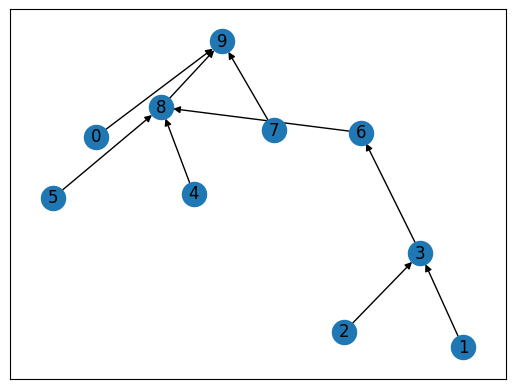

In [88]:
import networkx as nx

n = 10

adjacency_matrix = generate_random_dag(n, 0.2)

state_init_matrix = th.zeros_like(th.tensor(adjacency_matrix))
state_init_matrix[:, 0] = 1

batch_size_limit = th.zeros(n) + 2
batch_size_limit[-1] = th.inf

dists = generate_random_distributions(n, 10)

G = nx.from_numpy_matrix(adjacency_matrix, create_using=nx.DiGraph)

pos = nx.spring_layout(G)  # Positions for all nodes

nx.draw_networkx(G, pos, with_labels=True, arrows=True)
plt.show()

In [89]:
graph = ProdGraph(adjacency_matrix, dists, state_init_matrix, batch_size_limit, batch_size=100)


while graph.lapsed_time < 1000:
    graph.forward()

/tmp/ipykernel_1644/1061397986.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_limits = th.tensor(buffer_limits)
/tmp/ipykernel_1644/1061397986.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.states = th.tensor(initialization)


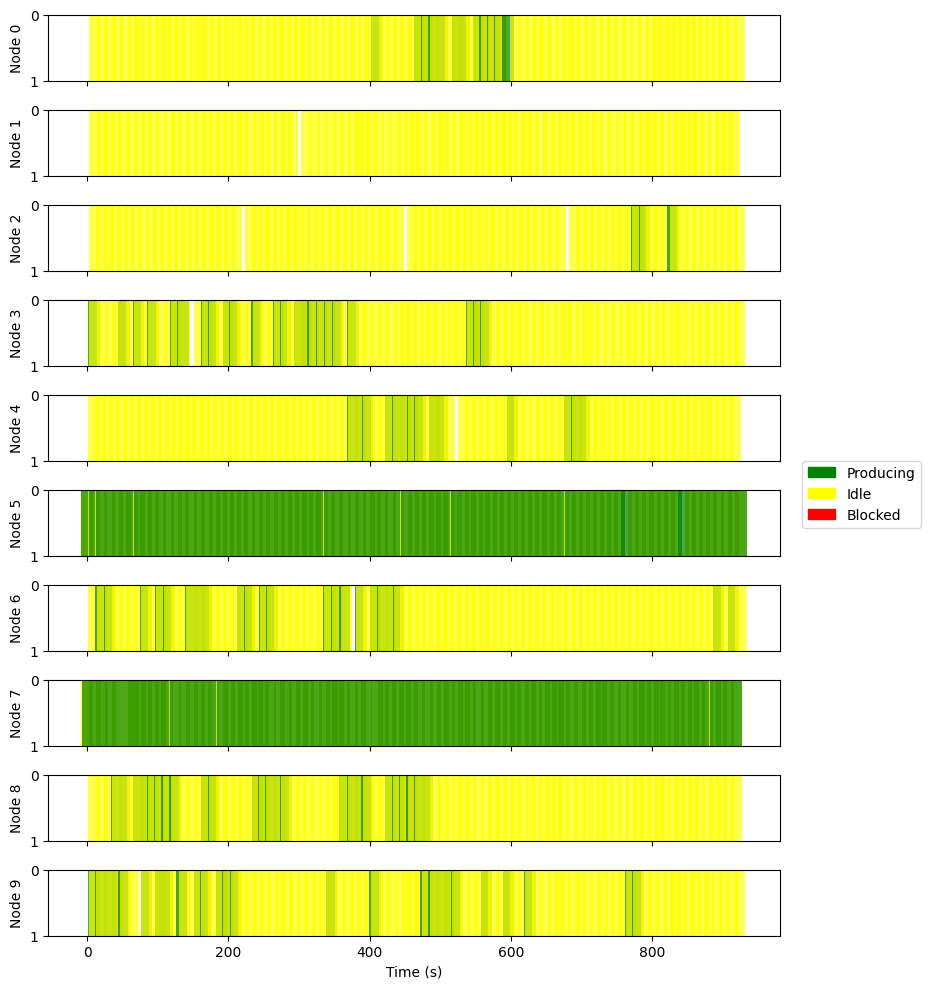

In [92]:
plot_time_series_producing(graph, 10)

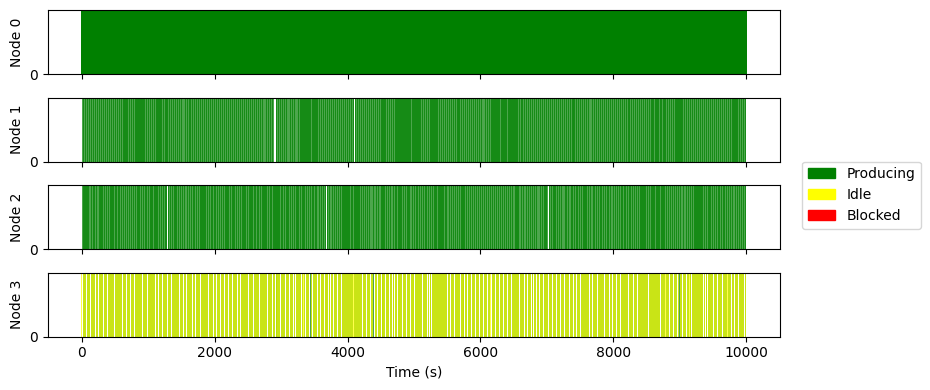

In [53]:
# Create a figure and axis for each subplot
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, 4))

# Sample time series data
time_0 = graph.log[graph.log['node'] == 0]['time']
time_1 = graph.log[graph.log['node'] == 1]['time']
time_2 = graph.log[graph.log['node'] == 2]['time']
time_3 = graph.log[graph.log['node'] == 3]['time']

data_0 = graph.log[graph.log['node'] == 0]['state']
data_1 = graph.log[graph.log['node'] == 1]['state']
data_2 = graph.log[graph.log['node'] == 2]['state']
data_3 = graph.log[graph.log['node'] == 3]['state']

graph.log[graph.log['node'] == 0]['state']

# Define color mapping
colors = {0: 'green', 1: 'yellow', 2: 'red'}

# Plot each time series with colored backgrounds
for ax, time, data, label in zip(axs, [time_0, time_1, time_2, time_3], [data_0, data_1, data_2, data_3], ['Node 0', 'Node 1', 'Node 2', 'Node 3']):
    for t, state in zip(time, data):
        ax.axvspan(t - 8, t + 8, facecolor=colors[state], alpha=0.7)
    ax.set_yticks([0])
    ax.set_yticklabels(['0'])
    ax.set_ylabel(label)
    
# Add legend
legend_labels = {'0': 'Producing', '1': 'Idle', '2': 'Blocked'}
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[int(label)]) for label in legend_labels.keys()]
fig.legend(legend_handles, legend_labels.values(), loc='center left', bbox_to_anchor=(1, 0.5))

# Set common xlabel
plt.xlabel('Time (s)')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()